# EarthCODE - Creating an openEO Experiment
This notebook provides a step-by-step guide on using the [CDSE openEO federation](https://documentation.dataspace.copernicus.eu/APIs/openEO/federation/openeo_federation.html) tools to create an experiment, which can later be published on the EarthCODE Science Catalogue to share with the broader scientific community. Through this example, you will learn how to define and execute a reproducible EO processing experiment using openEO.

We will start by constructing a simple workflow that calculates a  Enhanced Vegetation Index (EVI) time series. Using openEO, we will create a [user-defined process](https://open-eo.github.io/openeo-python-client/udp.html) that encapsulates this workflow. Once the workflow is defined, we will set up a dedicated experiment where it is executed with a specific set of parameters and input datasets, ultimately generating an output product.

By the end of this notebook, you will have a clear understanding of how to develop, structure, and share openEO-based experiments.

## Setup connection with openEO
The first step, before creating any processing workflow in openEO, is to authenticate with an available openEO backend. In this example, we will use the CDSE openEO federation, which provides seamless access to both datasets and processing resources across multiple federated openEO backends.

Currently, the federation includes access to the CDSE and Terrascope backends, enabling users to leverage diverse EO datasets and scalable cloud-based processing resources.

In [1]:
import openeo

In [2]:
connection = openeo.connect(url="openeofed.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


## Creating an openEO Workflow
In this example, we will implement a workflow to calculate the  Enhanced Vegetation Index (EVI) time series. This approach helps highlight the regions with the most significant vegetation activity over time while filtering out lower values that might be caused by atmospheric disturbances or cloud cover.

This example provides a clear demonstration of the key steps involved in creating an openEO workflow. Since EVI is derived using a straightforward mathematical formula, the focus here is on structuring a valid and reusable openEO workflow rather than the complexity of the calculation itself. Through this process, users will learn how to define input parameters, apply openEO processes, and generate meaningful outputs that can be further analyzed or shared.

### Defining workflow parameters
The first step in creating an openEO workflow is specifying the [input parameters](https://open-eo.github.io/openeo-python-client/api.html#openeo.api.process.Parameter). These parameters enable users to execute the workflow with their own custom settings, making it adaptable to different datasets and use cases. openEO provides built-in [helper functions](https://open-eo.github.io/openeo-python-client/udp.html#process-parameters) that assist in defining these parameters correctly.

In [3]:
from openeo.api.process import Parameter

In [4]:
area_of_interest = Parameter.geojson(name='spatial_extent', description="Spatial extent for which to generate the EVI")
time_of_interest = Parameter.temporal_interval(name='temporal_interval', description="Temporal extent specified as two-element array with start and end date/date-time used to generate the EVI")
max_cloud_cover = Parameter.number(name='max_cloud_cover', description="Maximum cloud cover to allow when selecting the observations to calculate the EVI", default=90)

### Implementing the EVI calculation  
Now that we have defined the input parameters, the next step is to implement the logic for generating the Enhanced Vegetation Index (EVI). This involves using openEO processes to apply the [EVI formula](https://en.wikipedia.org/wiki/Enhanced_vegetation_index) and incorporating the previously defined parameters. By leveraging openEO's built-in functions, we can efficiently process the input data and compute the EVI index as part of our workflow.

In this first step, we are creating our initial datacube based on the provided input parameters and the bands that are needed to calculate the EVI.

In [5]:
collection = "SENTINEL2_L2A"

In [6]:
# Create the cloud mask
scl = connection.load_collection(
    collection,
    spatial_extent=area_of_interest,
    temporal_extent=time_of_interest,
    bands=["SCL"],
    max_cloud_cover=max_cloud_cover,
)

cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)

In [7]:
# Create S2 datacube and mask it
s2_cube = connection.load_collection(
    collection,
    spatial_extent=area_of_interest,
    temporal_extent=time_of_interest,
    bands=["B02", "B04", "B08"],
    max_cloud_cover=max_cloud_cover
)
s2_bands_masked = s2_cube.mask(cloud_mask)
s2_bands_masked = s2_bands_masked.mask_polygon(area_of_interest)

Next, we implement the EVI formula by selecting the bands from our datacube and applying the band math functions.

In [8]:
blue = s2_bands_masked.band("B02") * 0.0001
red = s2_bands_masked.band("B04") * 0.0001
nir = s2_bands_masked.band("B08") * 0.0001

evi_cube = 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0)

### Creating the workflow
The final step in our process is to encapsulate the EVI computation into an openEO [User-Defined Process (UDP)](https://open-eo.github.io/openeo-python-client/udp.html). A UDP allows us to package the entire workflow into a single callable function that can be executed by its name. This not only makes the workflow reusable but also ensures that it can be shared with other users who may want to apply the same processing logic to different regions.

By making the UDP public, other researchers and users can seamlessly execute the workflow with their own set of input parameters, fostering collaboration and promoting open science principles. Additionally, if the UDP is publicly available, it can be published in the EarthCODE Open Science Catalogue, enabling broader scientific communities to access, reproduce, and build upon the experiment.

In [9]:
connection.save_user_defined_process(
    "evi_timeseries",
    evi_cube,
    parameters=[area_of_interest, time_of_interest, max_cloud_cover],
    public=True
)

Preflight process graph validation raised: [UpstreamValidationInfo] Backend 'cdse' reported validation errors [ProcessParameterRequired] Process 'n/a' parameter 'spatial_extent' is required.


## Creating an experiment
With our workflow successfully created as an openEO UDP, we can now set up an experiment. This involves executing the workflow with a predefined set of input parameters, allowing us to analyze specific datasets under controlled conditions. By specifying parameters such as the area of interest, time range, we can tailor the experiment to generate meaningful results.

Running the experiment will produce output products, which will be displayed at the end of the notebook. These results can then be further analyzed, shared with the scientific community, or published in the EarthCODE Open Science Catalogue to promote reproducibility and collaboration.

The first step is to define the parameters that we want to provide for our experiment. This is based on the parameters that were defined for our workflow.

In [10]:
spatial_extent_value = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              5.237940082258575,
              51.261328505909376
            ],
            [
              5.2592841876327725,
              51.24912709441142
            ],
            [
              5.271576732017934,
              51.25238044945303
            ],
            [
              5.263267882571938,
              51.266697225027485
            ],
            [
              5.237940082258575,
              51.261328505909376
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

temporal_interval_value = ['2024-01-01', '2024-12-31']

We can now execute our experiment using the `datacube_from_process` function and the information from the workflow we created:

* `process_id`: the ID that we have assigned to our workflow
* `namespace`: the public URL of the workflow, which is provided as output of the `save_user_defined_process` call
* `**kwargs`: the parameters of the workflow. If a parameter is not specified, its default value will be used

In [11]:
evi_datacube = connection.datacube_from_process(
    process_id="evi_timeseries",
    namespace="https://openeo.dataspace.copernicus.eu/openeo/1.1/processes/u:6391851f-9042-4108-8b2a-3dd2e8a9dd0b/evi_timeseries",
    spatial_extent=spatial_extent_value,
    temporal_interval=temporal_interval_value
)

The final step is to execute the experiment by submitting it to the connected openEO backend. This triggers the processing workflow using the specified input parameters. Once the execution begins, the backend will process the request and generate the output products. The results are automatically downloaded to the path specified in the [`execute_batch`](https://open-eo.github.io/openeo-python-client/api.html#openeo.rest.datacube.DataCube.execute_batch) command, allowing for further analysis and visualization.

Note that we are also providing a `title` and `description` to the actual experiments. This information will be reused when publishing the experiment into the EarthCODE Open Science Catalogue.

In [30]:
evi_datacube.execute_batch(
    "./evi_experiment_timeseries.nc",
    title="CDSE Federation - EVI Timeseries Experiment - Example - Belgium", 
    description="This is an example experiment from CDSE containing the calculation of the EVI timeseries for fields in Belgium",
)


0:00:00 Job 'cdse-j-250304093016466b96baec92978c4528': send 'start'
0:00:14 Job 'cdse-j-250304093016466b96baec92978c4528': created (progress 0%)
0:00:20 Job 'cdse-j-250304093016466b96baec92978c4528': created (progress 0%)
0:00:26 Job 'cdse-j-250304093016466b96baec92978c4528': created (progress 0%)
0:00:34 Job 'cdse-j-250304093016466b96baec92978c4528': created (progress 0%)
0:00:46 Job 'cdse-j-250304093016466b96baec92978c4528': created (progress 0%)
0:00:59 Job 'cdse-j-250304093016466b96baec92978c4528': running (progress N/A)
0:01:15 Job 'cdse-j-250304093016466b96baec92978c4528': running (progress N/A)
0:01:34 Job 'cdse-j-250304093016466b96baec92978c4528': running (progress N/A)
0:01:59 Job 'cdse-j-250304093016466b96baec92978c4528': running (progress N/A)
0:02:29 Job 'cdse-j-250304093016466b96baec92978c4528': running (progress N/A)
0:03:07 Job 'cdse-j-250304093016466b96baec92978c4528': running (progress N/A)
0:03:54 Job 'cdse-j-250304093016466b96baec92978c4528': running (progress N/A)
0

<BatchJob job_id='cdse-j-250304093016466b96baec92978c4528'>

## Visualize the result
Once the experiment has been executed, we can visualize the output product to assess the results and validate the workflow.

(array([19754., 19783., 19814., 19844., 19875., 19905., 19936., 19967.,
        19997., 20028., 20058., 20089.]),
 [Text(19754.0, 0, '2024-02'),
  Text(19783.0, 0, '2024-03'),
  Text(19814.0, 0, '2024-04'),
  Text(19844.0, 0, '2024-05'),
  Text(19875.0, 0, '2024-06'),
  Text(19905.0, 0, '2024-07'),
  Text(19936.0, 0, '2024-08'),
  Text(19967.0, 0, '2024-09'),
  Text(19997.0, 0, '2024-10'),
  Text(20028.0, 0, '2024-11'),
  Text(20058.0, 0, '2024-12'),
  Text(20089.0, 0, '2025-01')])

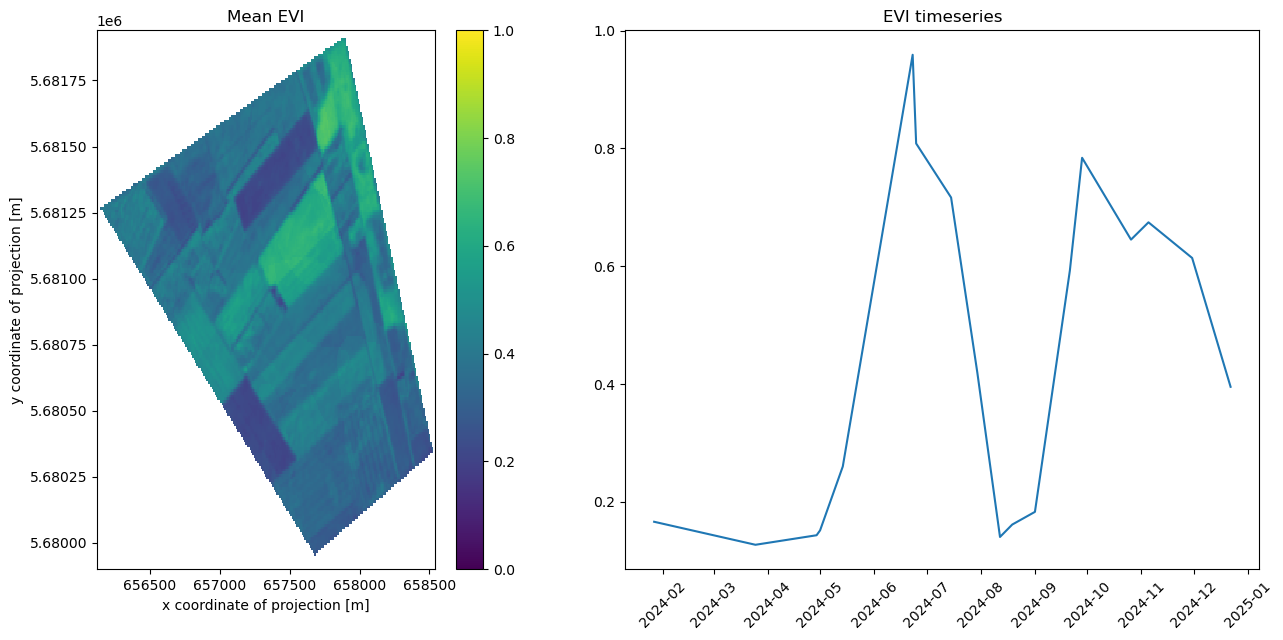

In [71]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec

ds = xr.load_dataset("./evi_experiment_timeseries.nc")
data = ds[["var"]].to_array(dim="bands")

timeseries_point = data.sel(x=657951, y=5680611, bands='var', method='nearest').dropna(dim='t')

fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])

# # Plot the image
ax0 = plt.subplot(gs[0])
data.mean(dim="t")[0].plot.imshow(vmin=0, vmax=1, ax=ax0)
ax0.set_title("Mean EVI")

# Plot the timeseries
ax1 = plt.subplot(gs[1])
ax1.plot(timeseries_point.t.values, timeseries_point.values)
ax1.set_title("EVI timeseries")

plt.xticks(rotation=45)

## Next steps
After generating and verifying the output, the next step is to publish the experiment to the EarthCODE Open Science Catalogue. This allows other researchers to discover, access, and reuse the workflow, contributing to open and reproducible science.